In [ ]:
import numpy as np
import torch
# Local utilities
from utils import (
    load_data,
    plot_true_vs_pred,
    compute_effect,
    compute_metric,
)
from simulation import (
    simulate_treatment,
    compute_outcome,
)
from interference import run_gcn_experiment
from propensity import fit_propensity
from mean import fit_mean

In [3]:
# Data_path "Flickr_New.npz" or "BC_New.npz"
path="Flickr_New.npz"
# Feature name lda_10, lda_5, pca_10, pca_5, lda_supervised
feature_name="lda_supervised"
# Fold number 0,1,2,3,4
fold_num=2
X,adj_matrix,X_val,adj_matrix_val,X_test,adj_matrix_test=load_data(path,feature_name,fold_num)

In [4]:
# Larger, propensity score more extreme to 0 or 1
beta=1
# Larger, propensity score shift to 1
alpha=2
# Larger, more weight on larger attention
sparse_param=5
# Noise level
sigma=0.05
# Larger, higher spillover effect/base effect
scale=5
# Attention type "cosine" or "rbf" or "homo" or "heter"
attention_type="cosine"
# Num of num_partitions
num_partition=3
# Train
one_hop_neighbors, n, d, partitions, treat_binary, e_star, treat_neighbor, treat_matrix=simulate_treatment(X, adj_matrix, mode="train",beta=beta, alpha=alpha,num_partitions=num_partition)
true_attention, spillover, U_0, noise, y, m_star =\
 compute_outcome(X, adj_matrix, treat_matrix, e_star, n, sigma, scale, sparse_param,attention_type)
IME, ISE, ITE = compute_effect(true_attention, adj_matrix)

# Test
one_hop_neighbors_test, n_test, d_test, partitions_test, treat_binary_test, e_star_test, treat_neighbor_test, treat_matrix_test=\
  simulate_treatment(X_test, adj_matrix_test,mode="test",beta=beta, alpha=alpha)
true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test =\
 compute_outcome(X_test, adj_matrix_test, treat_matrix_test, e_star_test, n_test, sigma, scale, sparse_param,attention_type)
IME_test, ISE_test, ITE_test = compute_effect(true_attention_test, adj_matrix_test)

In [ ]:
# Setting hyperparmeters
propensity_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 100}
mean_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 100}

ehat,propensity_models = fit_propensity(X, adj_matrix, treat_binary, y, m_star, partitions, propensity_params,print_logs=True,aug=False,device="cpu")
mhat,mean_models = fit_mean(X, adj_matrix, treat_binary, y,
                                       m_star, ehat, partitions, mean_params,
                                       bagging=True, aug=True,
                                       print_logs=True,agg_method='mean',device="cpu")

Partition: 0, epoch: 050 - New best Testing Loss: 0.4598
Partition: 0, epoch: 100 - New best Testing Loss: 0.4007
Partition: 1, epoch: 050 - New best Testing Loss: 0.4577
Partition: 1, epoch: 100 - New best Testing Loss: 0.4245
Partition: 2, epoch: 050 - New best Testing Loss: 0.4425
Partition: 2, epoch: 100 - New best Testing Loss: 0.4084
Partition: 0, epoch: 050 - New best Testing Loss: 0.0193
Partition: 0, epoch: 100 - New best Testing Loss: 0.0107
Partition: 1, epoch: 050 - New best Testing Loss: 0.0155
Partition: 1, epoch: 100 - New best Testing Loss: 0.0085
Partition: 2, epoch: 050 - New best Testing Loss: 0.0116
Partition: 2, epoch: 100 - New best Testing Loss: 0.0068
Improved by bagging


37.58344546223464
34.20519397960706


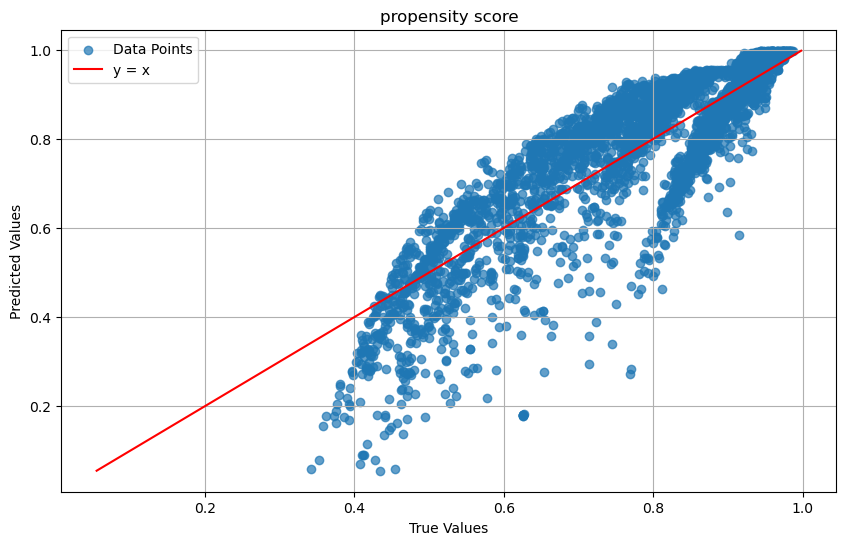

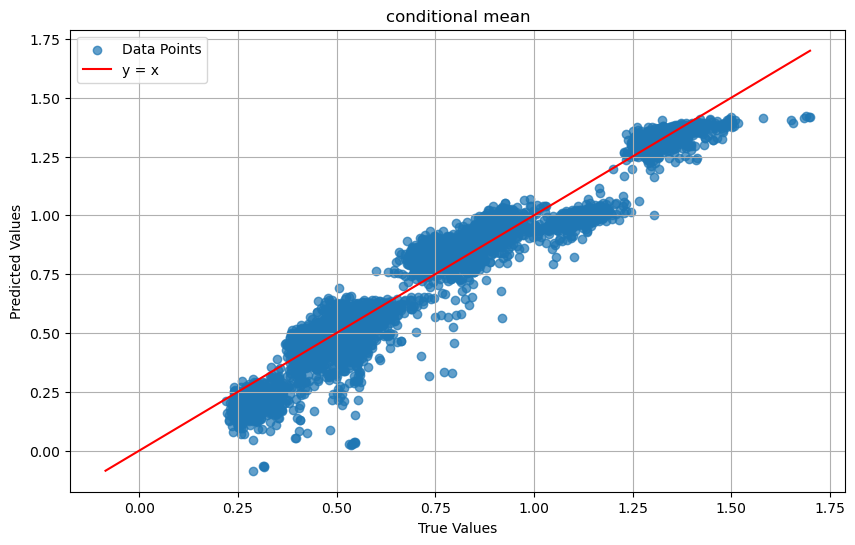

In [6]:
print(np.sum((mhat-m_star)**2))
print(np.sum((ehat-e_star)**2))

plot_true_vs_pred(ehat,e_star,title_name="propensity score")
plot_true_vs_pred(mhat,m_star,title_name="conditional mean")

Epoch 001, New best Spillover diff: 925.1388
Epoch 002, New best Spillover diff: 748.6901
Epoch 003, New best Spillover diff: 605.2013
Epoch 004, New best Spillover diff: 510.8229
Epoch 005, New best Spillover diff: 452.2516
Epoch 006, New best Spillover diff: 390.3155
Epoch 007, New best Spillover diff: 316.1403
Epoch 008, New best Spillover diff: 251.9223
Epoch 009, New best Spillover diff: 202.4474
Epoch 010, New best Spillover diff: 164.1825
Epoch 011, New best Spillover diff: 133.3767
Epoch 012, New best Spillover diff: 111.2392
Epoch 013, New best Spillover diff: 102.6565
Epoch 014, New best Spillover diff: 88.5642
Epoch 015, New best Spillover diff: 78.5591
Epoch 016, New best Spillover diff: 74.4045
Epoch 017, New best Spillover diff: 66.2331
Epoch 018, New best Spillover diff: 65.2937
Epoch 019, New best Spillover diff: 61.2083
No improve. Epoch 020, Spillover diff: 62.2504
Epoch 021, New best Spillover diff: 53.9215
Epoch 022, New best Spillover diff: 53.1377
Epoch 023, New b

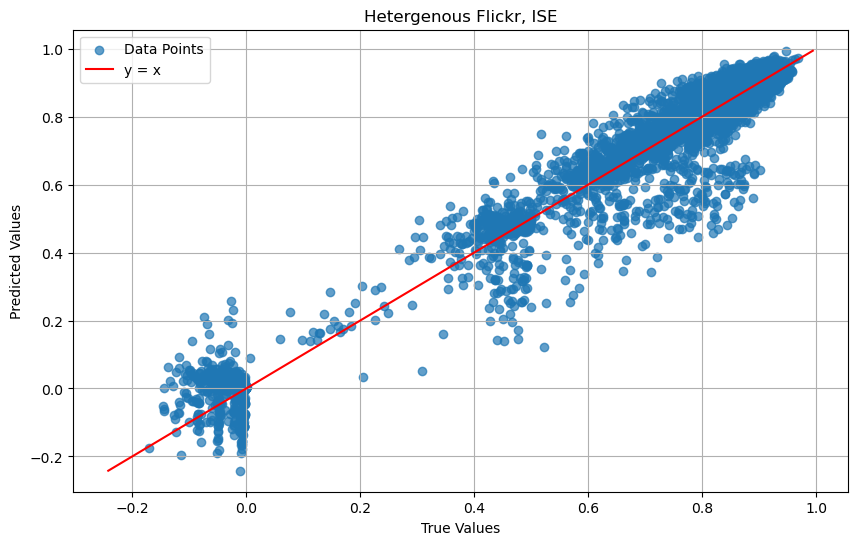

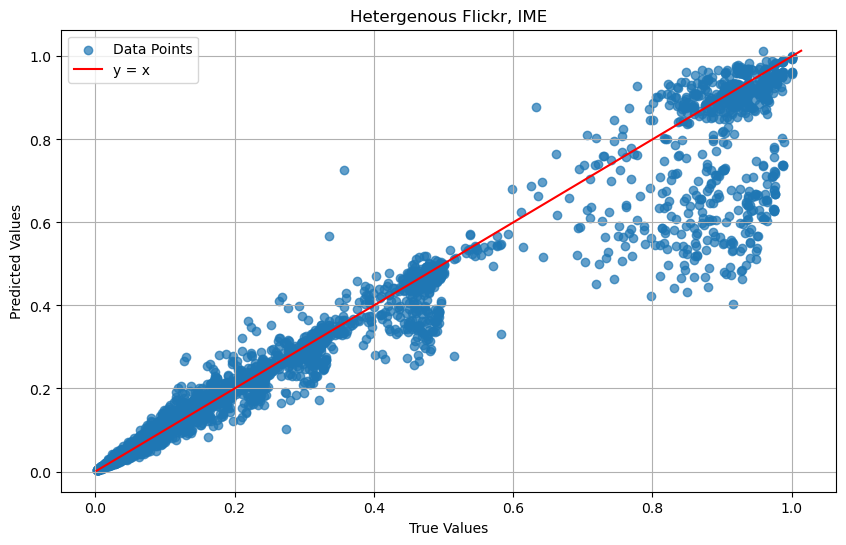

In [8]:
hidden_dim=64
spillover_params = {"epochs": 200, "lr": 0.0001, "batch_size": 64, "hidden_dim": hidden_dim}
best_model, best_loss, best_pred_attention = run_gcn_experiment(X, mhat, y, one_hop_neighbors,
                                                                  treat_binary, ehat, true_attention,
                                                                  adj_matrix, sparse_param, spillover_params,
                                                                printing=True, device="cpu")
with torch.no_grad():
  best_predicted_attention,_ = best_model.cpu().predict(torch.tensor(X, dtype=torch.float32), one_hop_neighbors, treat_binary)
IME_est, ISE_est, ITE_est = compute_effect(best_predicted_attention, adj_matrix)
print("Proposed: training set")
Result_train=compute_metric(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=True)

with torch.no_grad():
  attention_test,_ = best_model.predict(torch.tensor(X_test, dtype=torch.float32), one_hop_neighbors_test, treat_binary_test)
IME_est_test, ISE_est_test, ITE_est_test = compute_effect(attention_test, adj_matrix_test)
print("Proposed: testing set")
Result_test=compute_metric(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=True)

plot_true_vs_pred(ISE,ISE_est,title_name="Hetergenous Flickr, ISE")
plot_true_vs_pred(IME,IME_est,title_name="Hetergenous Flickr, IME")

In [9]:
print(np.mean(ISE)-np.mean(ISE_est))
# print(np.mean(ISE_est))
print(np.mean(IME_test)-np.mean(IME_est_test))
print(np.mean(ITE)-np.mean(ITE_est))


-0.00617218
0.015947223
0.011023402
